<center>
<h1> Yasin Fakhar - 4003644010 </h1>
<h2><b>Impelementation of "article X_vector anonymization using auto-encoder and adversial training"</b></h2>
</center>

in this article the authors used X-vector for speaker embedding but I use D-vector. They both do the same job.

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/D_vector

/content/drive/MyDrive/Colab Notebooks/D_vector


In [ ]:
!wget https://github.com/yistLin/dvector/releases/download/v1.1.1/wav2mel.pt
!wget https://github.com/yistLin/dvector/releases/download/v1.1.1/dvector-step250000.pt
!wget https://github.com/yistLin/dvector/releases/download/v1.1.1/sox_effects.pt
!wget https://github.com/yistLin/dvector/releases/download/v1.1.1/log_melspectrogram.pt

In [ ]:
!git clone https://github.com/tadeephuy/GradientReversal.git
%cp -r GradientReversal/gradient_reversal .

Cloning into 'GradientReversal'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 32 (delta 7), reused 29 (delta 4), pack-reused 0
Unpacking objects: 100% (32/32), 141.54 KiB | 283.00 KiB/s, done.


In [ ]:
!pip install opendatasets

importing libraries

In [ ]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import seaborn as sns
from tqdm import tqdm
import opendatasets as od
from gradient_reversal import GradientReversal
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!mkdir trained_model
!mkdir data
%cd data

/content/drive/MyDrive/Colab Notebooks/D_vector/data


# Downloading Data

downloading data from Kaggle.com

In [ ]:
od.download("https://www.kaggle.com/datasets/kongaevans/speaker-recognition-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: workyasin
Your Kaggle Key: ··········


100%|██████████| 231M/231M [00:04<00:00, 51.2MB/s]


configuration

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/D_vector/data'
model_path = '/content/drive/MyDrive/Colab Notebooks/D_vector'

warning_code = '\033[94m'
end_code = '\033[0m'

# Data Processing

function for speaker embedding

In [ ]:
wav2mel = torch.jit.load(model_path + "/wav2mel.pt")
dvector = torch.jit.load(model_path + "/dvector-step250000.pt").eval()

def wav_to_vec(wav_path):
  wav_tensor, sample_rate = torchaudio.load(wav_path)
  mel_tensor = wav2mel(wav_tensor, sample_rate)  # shape: (frames, mel_dim)
  emb_tensor = dvector.embed_utterance(mel_tensor)  # shape: (emb_dim)
  return emb_tensor

In [ ]:
speaker_emb = wav_to_vec(dataset_path + "/speaker-recognition-dataset/16000_pcm_speeches/Benjamin_Netanyau/0.wav")
print(f'speaker embedded in {speaker_emb.shape[0]} dimentional space')

speaker embedded in 256 dimentional space


reading dataset

In [ ]:
speakers_folder_names = os.listdir(dataset_path + "/speaker-recognition-dataset/16000_pcm_speeches")
speakers_folder_names.remove('other')
speakers_folder_names.remove('tf_Wav_reader.py')
speakers_folder_names.remove('_background_noise_')
print(f'list of speakers : {speakers_folder_names}')

y = []
X = []
for idx in range(len(speakers_folder_names)):
  utterances_path = dataset_path + "/speaker-recognition-dataset/16000_pcm_speeches/" + speakers_folder_names[idx]
  print(f'converting utterances for {speakers_folder_names[idx]}')
  for id in tqdm(os.listdir(utterances_path)):
    try:
      speaker_embbedding  = wav_to_vec(utterances_path + "/" + id).detach().numpy()
      X.append(speaker_embbedding)
      y.append(idx)
    except:
      # print(f'{warning_code} {utterances_path + "/" + id} could not be processed {end_code}')
      pass

X = np.array(X)
y = np.array(y)

list of speakers : ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']
converting utterances for Benjamin_Netanyau


100%|██████████| 1500/1500 [01:00<00:00, 24.86it/s]


converting utterances for Jens_Stoltenberg


100%|██████████| 1500/1500 [00:53<00:00, 27.83it/s]


converting utterances for Julia_Gillard


100%|██████████| 1501/1501 [01:03<00:00, 23.72it/s]


converting utterances for Magaret_Tarcher


100%|██████████| 1500/1500 [01:03<00:00, 23.69it/s]


converting utterances for Nelson_Mandela


100%|██████████| 1500/1500 [01:07<00:00, 22.07it/s]


In [ ]:
print(f'total number of utterances : {X.shape[0]}')

total number of utterances : 7484


plotting T-SNE

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


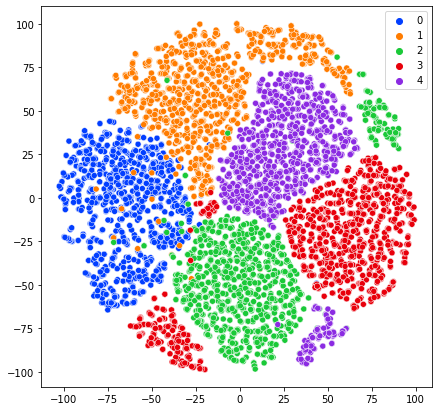

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3, random_state=123).fit_transform(X)
palette = sns.color_palette("bright", 5)
plt.figure(figsize=(7,7))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.show()

# Creating Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, speaker_emb, labels):
        self.labels = labels
        self.speaker_emb = speaker_emb

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.speaker_emb[idx]
        return data , label

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {device}')

X_ = torch.tensor(X, requires_grad=True,dtype=torch.float32).to(device)
y_ = torch.tensor(y,dtype=torch.float32).to(device)
X_ = X_.type(torch.FloatTensor)
y_ = y_.type(torch.FloatTensor)
DS = CustomDataset(X_, y_)

using cuda


#Building Network

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
                nn.Linear(256, 128),
                nn.Tanh(),
                nn.Linear(128, 64),
                nn.Tanh()
                )
    
    self.decoder = nn.Sequential(
                nn.Linear(64, 128),
                nn.Tanh(),
                nn.Linear(128, 256),
                nn.Tanh()
                )
    
    self.discriminator = nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 5),
                nn.LogSoftmax(dim=1),
                GradientReversal(alpha=1)
                )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    discriminator = self.discriminator(encoded)
    return decoded , discriminator

In [ ]:
model = AutoEncoder().to(device)

loss_AE = torch.nn.MSELoss()
loss_DA = torch.nn.NLLLoss()
 
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

epochs = 10
batch_size = 64
outputs = []
losses = []
for epoch in range(epochs):

    data_loader = DataLoader(DS, batch_size=batch_size, shuffle=True)
    total_domain_loss = total_label_accuracy = 0
    for (input, label) in tqdm(data_loader):
      input = input.to(device)
      label = label.to(device)

      # Output of Autoencoder , Domain classifier
      reconstructed , domain = model(input)
       
      # Calculating the loss function
      loss_ae = loss_AE(reconstructed, input)
      domain = domain.type(torch.FloatTensor)
      label = label.type(torch.LongTensor)
      loss_da = loss_DA(domain, label)
       
      #performs parameter update
      optimizer.zero_grad()
      loss = loss_ae + loss_da
      loss.backward()
      optimizer.step()
       
      total_domain_loss += loss_da.item()
      total_label_accuracy += (domain.max(1)[1] == label).float().mean().item()
      losses.append(loss.cpu().detach().numpy())
    
    mean_loss = total_domain_loss / batch_size
    mean_accuracy = total_label_accuracy / batch_size

    tqdm.write(f'EPOCH {epoch:02d}: domain_loss={loss_da:.4f}, '
                   f'autoencoder_loss={loss_ae:.4f} , total_loss={loss:.4f}, mean_accuracy={mean_accuracy:.4f}, mean_loss={mean_loss:.4f}')

    torch.save(model.state_dict(), 'trained_model/model.pt')
    outputs.append((epochs, speaker_emb, reconstructed))

100%|██████████| 117/117 [00:12<00:00,  9.36it/s]


EPOCH 00: domain_loss=109671989248.0000, autoencoder_loss=0.9994 , total_loss=109671989248.0000, mean_accuracy=0.3692, mean_loss=29692742898.3729


100%|██████████| 117/117 [00:12<00:00,  9.44it/s]


EPOCH 01: domain_loss=3668597800960.0000, autoencoder_loss=0.9992 , total_loss=3668597800960.0000, mean_accuracy=0.3666, mean_loss=2334564403200.0000


100%|██████████| 117/117 [00:12<00:00,  9.37it/s]


EPOCH 02: domain_loss=27227483799552.0000, autoencoder_loss=0.9981 , total_loss=27227483799552.0000, mean_accuracy=0.3666, mean_loss=23279207489536.0000


100%|██████████| 117/117 [00:12<00:00,  9.43it/s]


EPOCH 03: domain_loss=98459986165760.0000, autoencoder_loss=1.0000 , total_loss=98459986165760.0000, mean_accuracy=0.3666, mean_loss=102880271990784.0000


100%|██████████| 117/117 [00:13<00:00,  8.55it/s]


EPOCH 04: domain_loss=265845020295168.0000, autoencoder_loss=0.9997 , total_loss=265845020295168.0000, mean_accuracy=0.3666, mean_loss=300880191684608.0000


100%|██████████| 117/117 [00:12<00:00,  9.38it/s]


EPOCH 05: domain_loss=576241870569472.0000, autoencoder_loss=0.9995 , total_loss=576241870569472.0000, mean_accuracy=0.3666, mean_loss=692076695781376.0000


100%|██████████| 117/117 [00:12<00:00,  9.45it/s]


EPOCH 06: domain_loss=992986708049920.0000, autoencoder_loss=0.9999 , total_loss=992986708049920.0000, mean_accuracy=0.3666, mean_loss=1360744896004096.0000


100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


EPOCH 07: domain_loss=1615143658061824.0000, autoencoder_loss=1.0008 , total_loss=1615143658061824.0000, mean_accuracy=0.3666, mean_loss=2401089026523136.0000


100%|██████████| 117/117 [00:14<00:00,  7.90it/s]


EPOCH 08: domain_loss=2768371904937984.0000, autoencoder_loss=0.9993 , total_loss=2768371904937984.0000, mean_accuracy=0.3666, mean_loss=3912100223123456.0000


100%|██████████| 117/117 [00:14<00:00,  8.13it/s]

EPOCH 09: domain_loss=3818192640147456.0000, autoencoder_loss=0.9991 , total_loss=3818192640147456.0000, mean_accuracy=0.3666, mean_loss=5991985135484928.0000


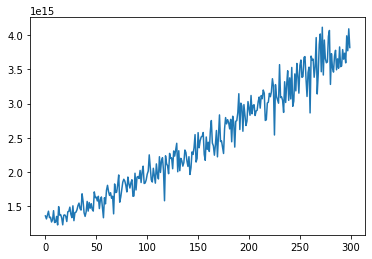

In [ ]:
plt.plot(losses[-300:])
plt.show()

In [ ]:
with torch.no_grad():
  reconstructed , domain = model(X_.to(device))
  print(reconstructed.shape)

torch.Size([7485, 256])


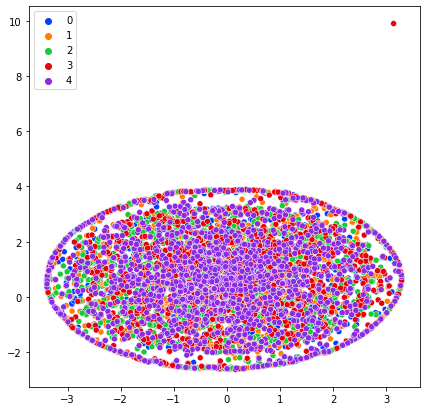

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3, random_state=123).fit_transform(reconstructed.cpu().detach().numpy())
palette = sns.color_palette("bright", 5)
plt.figure(figsize=(7,7))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.show()

As shown above the distribution of speakers are merged and it is indistinguishable for model.